In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, structure_optimization_lib

import paragami


In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

# Load data

In [4]:
n_obs=40
n_loci=50
n_pop=4

data = np.load('../simulated_data/simulated_structure_data_nobs{}_nloci{}_npop{}.npz'.format(
                    n_obs, n_loci, n_pop))

In [5]:
# population allele frequencies
true_pop_allele_freq = data['true_pop_allele_freq']

# individual admixtures
true_ind_admix_propn = data['true_ind_admix_propn']

# observations 
g_obs = data['g_obs']

assert n_obs == g_obs.shape[0]
assert n_loci == g_obs.shape[1]
assert n_pop == true_pop_allele_freq.shape[1]

print('true_number of populations: ', n_pop)

true_number of populations:  4


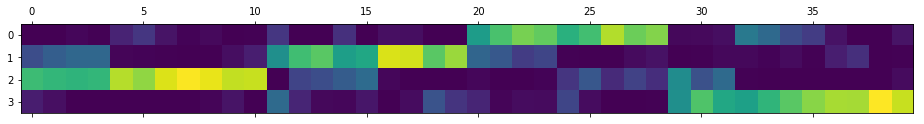

In [6]:
plt.matshow(true_ind_admix_propn.T)

# Load fit

In [7]:
vb_opt_dict, vb_params_paragami, fit_data =\
    paragami.load_folded('../fits/structure_fit_nobs40_nloci50_npop4_alpha5.0.npz')

# free optimal vb_parameters
vb_opt_free_params = vb_params_paragami.flatten(vb_opt_dict, free = True)

# load prior parameters
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()
prior_params_dict['dp_prior_alpha'] = fit_data['alpha']

# other parameters
use_logitnormal_sticks = fit_data['use_logitnormal_sticks']
if use_logitnormal_sticks: 
    gh_deg = int(data['gh_deg'])
    gh_loc, gh_weights = hermgauss(gh_deg)
else: 
    gh_loc = None
    gh_weights = None
    
# assert we are at an optimum 
structure_model_lib.assert_optimizer(g_obs, vb_opt_dict, vb_params_paragami, 
                                     prior_params_dict, gh_loc = gh_loc, gh_weights = gh_weights,
                                    use_logitnormal_sticks = use_logitnormal_sticks)

# check results

In [8]:
if use_logitnormal_sticks: 
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_opt_dict['ind_mix_stick_propn_mean'], 
                        vb_opt_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)

else: 
    ind_mix_stick_beta_params = vb_opt_dict['ind_mix_stick_beta_params']
    e_stick_lengths = \
            modeling_lib.get_e_beta(ind_mix_stick_beta_params)
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

e_pop_freq = modeling_lib.get_e_beta(vb_opt_dict['pop_freq_beta_params'])

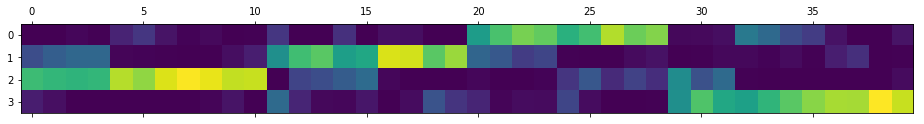

In [9]:
plt.matshow(true_ind_admix_propn.T)

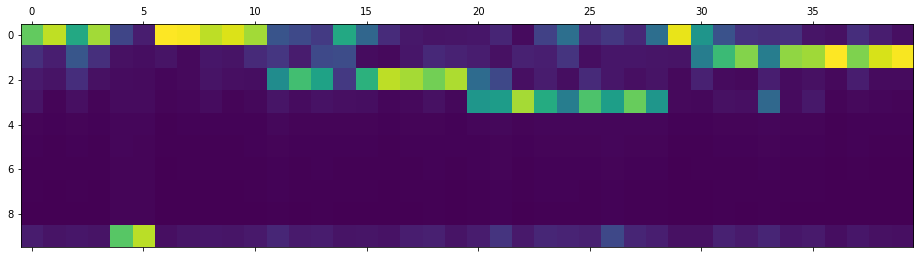

In [10]:
plt.matshow(e_ind_admix.T)